In [1]:
try:
    import gdal
except ImportError:
    from osgeo import gdal

In [2]:
! pip3 install utm
! pip3 install scikit-image
! pip3 install geopy

You should consider upgrading via the '/Users/dwannipurage3/code/veda/black-marble/venv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/dwannipurage3/code/veda/black-marble/venv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/dwannipurage3/code/veda/black-marble/venv/bin/python3 -m pip install --upgrade pip' command.


In [3]:
aws_access_key = ''
aws_secret_key = ''
# Get a token from https://urs.earthdata.nasa.gov/
earthdata_token = ''

In [4]:
import glob
import numpy as np
import os
from osgeo import ogr
import shapely.geometry
import shapely.wkt
import boto3
from datetime import datetime
from datetime import date
import utm
from numpy import inf
import matplotlib.pyplot as plt
import rasterio
import rasterio.features
import fiona
import fiona.transform
import requests
import osmnx as ox
import os.path
from pyproj import Proj
import json
import utm
from geopy.distance import geodesic

In [5]:

def get_geo(f, band):
    ds = gdal.Open(f, gdal.GA_ReadOnly)
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    img = ds.GetRasterBand(band).ReadAsArray(0,0,cols,rows)
    in_geo = ds.GetGeoTransform()
    projref = ds.GetProjectionRef()
    ds = None
    return img, in_geo, projref

def save_image(f,in_geo,projref,type,out):
    #create New Raster
    driver = gdal.GetDriverByName('GTiff')
    if driver == None:
        print ("Failed to find the gdal driver")
        exit()
    newRaster = driver.Create(out, f.shape[1], f.shape[0], 1, type)
    newRaster.SetProjection(projref)
    newRaster.SetGeoTransform(in_geo)
    outBand = newRaster.GetRasterBand(1)
    outBand.SetNoDataValue(0)
    outBand.WriteArray(f, 0, 0)
    driver = None
    outBand = None
    newRaster = None

def scale_image(inputarry, min_value, max_value):
    inputarry = np.where(inputarry > max_value, max_value,inputarry)
    inputarry = np.where(inputarry < min_value, min_value,inputarry)
    new_arr = ((inputarry - inputarry.min()) * (1/(inputarry.max() - inputarry.min()) * 255)).astype('uint8')
    return new_arr

def save_geotiff_rgb(filename, r, g, b, projref, in_geo):
  # Write a GeoTIFF
  format = 'GTiff'
  rows, cols = np.shape(r)
  driver = gdal.GetDriverByName(format)
  out_ds = driver.Create(filename, cols, rows, 3, gdal.GDT_Byte)
  out_ds.SetProjection(projref)
  out_ds.SetGeoTransform(in_geo)
  out_ds.GetRasterBand(1).WriteArray(r)
  out_ds.GetRasterBand(2).WriteArray(g)
  out_ds.GetRasterBand(3).WriteArray(b)
  out_ds = None

def save_geotiff_single(filename, band_data, projref, in_geo):
  # Write a GeoTIFF
  format = 'GTiff'
  rows, cols = np.shape(band_data)
  driver = gdal.GetDriverByName(format)
  out_ds = driver.Create(filename, cols, rows, 1, gdal.GDT_UInt16)
  out_ds.SetProjection(projref)
  out_ds.SetGeoTransform(in_geo)
  out_ds.GetRasterBand(1).WriteArray(band_data)
  out_ds = None

# https://blackmarble.gsfc.nasa.gov/tools/OpenHDF5.py
def convert_VNP46A2_HDF2TIFF(hf5File, outputFile):
    hdflayer = gdal.Open(hf5File, gdal.GA_ReadOnly)
    subhdflayer = hdflayer.GetSubDatasets()[2][0]
    rlayer = gdal.Open(subhdflayer, gdal.GA_ReadOnly)
    rasterFilePre = hf5File[:-3]
    HorizontalTileNumber = int(rlayer.GetMetadata_Dict()["HorizontalTileNumber"])
    VerticalTileNumber = int(rlayer.GetMetadata_Dict()["VerticalTileNumber"])
    WestBoundCoord = (10*HorizontalTileNumber) - 180
    NorthBoundCoord = 90-(10*VerticalTileNumber)
    EastBoundCoord = WestBoundCoord + 10
    SouthBoundCoord = NorthBoundCoord - 10
    EPSG = "-a_srs EPSG:4326" #WGS84
    translateOptionText = EPSG+" -a_ullr " + str(WestBoundCoord) + " " + str(NorthBoundCoord) + " " + str(EastBoundCoord) + " " + str(SouthBoundCoord)
    translateoptions = gdal.TranslateOptions(gdal.ParseCommandLine(translateOptionText))
    gdal.Translate(outputFile,rlayer, options=translateoptions)

def subset_raster_normal(inputRaster, outputRaster, minX, maxY, maxX, minY, scale):
  ds = gdal.Open(inputRaster)
  #extended BBox
  top1 = maxY
  left1 = minX
  bottom1 = minY
  right1 = maxX
  ds = gdal.Translate('new1.tif', inputRaster, projWin = [left1, top1, right1, bottom1], resampleAlg='bilinear')
  ds = None
  ds = gdal.Open('new1.tif')
  ds = gdal.Warp('new2.tif', ds, xRes=scale, yRes=scale, resampleAlg='bilinear')
  ds = None
  ds = gdal.Open('new2.tif')
  ds = gdal.Translate(outputRaster, ds, projWin = [minX, maxY, maxX, minY], resampleAlg='bilinear')
  ds = None
  os.remove('new1.tif')
  os.remove('new2.tif')

In [6]:
# https://github.com/robintw/LatLongToWRS/blob/master/get_wrs.py

class LandsatUtil:
    """Class which performs conversion between latitude/longitude co-ordinates
    and Landsat WRS-2 paths and rows.
    Requirements:
    * OGR (in the GDAL suite)
    * Shapely
    * Landsat WRS-2 Path/Row Shapefiles - download from USGS site
     (http://landsat.usgs.gov/tools_wrs-2_shapefile.php), you want wrs2_descending.zip
    Usage:
    1. Create an instance of the class:
        conv = ConvertToWRS()
    (This will take a while to run, as it loads
    the shapefiles in to memory)
    2. Use the get_wrs method to do a conversion:
        print conv.get_wrs(50.14, -1.43)
    For example:
        >>> conv = ConvertToWRS()
        >>> conv.get_wrs(50.14, -1.7)
        [{'path': 202, 'row': 25}]
        >>> conv.get_wrs(50.14, -1.43)
        [{'path': 201, 'row': 25}, {'path': 202, 'row': 25}]
    """
    def __init__(self, shapefile="./WRS2_descending.shp"):
        """Create a new instance of the ConvertToWRS class,
        and load the shapefiles into memory.
        If it can't find the shapefile then specify the path
        using the shapefile keyword - but it should work if the
        shapefile is in the same directory.
        """
        # Open the shapefile
        self.shapefile = ogr.Open(shapefile)
        # Get the only layer within it
        self.layer = self.shapefile.GetLayer(0)
        self.polygons = []
        # For each feature in the layer
        for i in range(self.layer.GetFeatureCount()):
            # Get the feature, and its path and row attributes
            feature = self.layer.GetFeature(i)
            path = feature['PATH']
            row = feature['ROW']
            # Get the geometry into a Shapely-compatible
            # format by converting to Well-known Text (Wkt)
            # and importing that into shapely
            geom = feature.GetGeometryRef()
            shape = shapely.wkt.loads(geom.ExportToWkt())
            # Store the shape and the path/row values
            # in a list so we can search it easily later
            self.polygons.append((shape, path, row))


    def get_wrs(self, lat, lon):
        """Get the Landsat WRS-2 path and row for the given
        latitude and longitude co-ordinates.
        Returns a list of dicts, as some points will be in the
        overlap between two (or more) landsat scene areas:
        [{path: 202, row: 26}, {path:186, row=7}]
        """
        # Create a point with the given latitude
        # and longitude (NB: the arguments are lon, lat
        # not lat, lon)
        pt = shapely.geometry.Point(lon, lat)
        res = []
        # Iterate through every polgon
        for poly in self.polygons:
            # If the point is within the polygon then
            # append the current path/row to the results
            # list
            if pt.within(poly[0]):
                res.append({'path': poly[1], 'row': poly[2]})
        # Return the results list to the user
        return res

    def filter_landsat_data_dir(self, year, month, day, path, row):

        year = str(year)
        month = str(month).zfill(2)
        day = str(day).zfill(2)
        session = boto3.Session( aws_access_key_id= aws_access_key, aws_secret_access_key= aws_secret_key)
        s3 = session.client('s3')
        directories = s3.list_objects_v2(
            Bucket='usgs-landsat',
            Prefix='collection02/level-2/standard/oli-tirs/' + str(year) + '/' + path + '/' + row + '/',
            RequestPayer='requester',
            Delimiter='/'
        )['CommonPrefixes']
        selected_start_date = None
        selected_end_date = None
        selected_prefix = None
        for entry in directories:
            date_range = entry['Prefix'].split('/')[-2].split('_')[3:5]
            target_date = datetime.strptime(year + month + day, '%Y%m%d')
            start_date = datetime.strptime(date_range[0], '%Y%m%d')
            end_date = datetime.strptime(date_range[1], '%Y%m%d')
            if target_date >= start_date and target_date <= end_date:
                if selected_start_date:
                    if selected_start_date < start_date and selected_end_date > end_date:
                        selected_prefix = entry['Prefix']
                        selected_start_date = start_date
                        selected_end_date = end_date
                else:    
                    selected_prefix = entry['Prefix']
                    selected_start_date = start_date
                    selected_end_date = end_date
        return selected_prefix
    
    def download_landsat_band(self, dir, band, output_path):
        if str(band) == 'QA_PIXEL':
            band_file = dir + dir.split('/')[-2] + "_QA_PIXEL.TIF"
            print("Downloading QA_PIXEL ", band_file)
        elif str(band) == 'QA_RADSAT':
            band_file = dir + dir.split('/')[-2] + "_QA_RADSAT.TIF"
            print("Downloading QA_RADSAT ", band_file)
        elif str(band) == 'QA_AEROSOL':
            band_file = dir + dir.split('/')[-2] + "_SR_QA_AEROSOL.TIF"
            print("Downloading QA_AEROSOL ", band_file)
        else:
            band_file = dir + dir.split('/')[-2] + "_SR_B" + str(band) + ".TIF"
            print("Downloading Band  ", band_file)
        session = boto3.Session( aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_key)
        s3 = session.client('s3')
        files = s3.list_objects_v2(
            Bucket='usgs-landsat',
            Prefix=band_file,
            RequestPayer='requester',
        )['Contents']
        print("Downloading file " + band_file + " to path "  + output_path)
        s3.download_file('usgs-landsat', band_file, output_path, ExtraArgs = {"RequestPayer": "requester"})


In [7]:
class OSMUtil:
    def create_road_raster_flattened(self, lat1, long1, lat2, long2, raster_value = 5,
                           reference_raster = "outputs/ntl.tif",
                           output_path= "outputs/osm.tif", path_thickness = 0.00005):
        with rasterio.open(reference_raster) as f:
                    height = f.height
                    width = f.width
                    crs = f.crs.to_string()
                    transform = f.transform
                    crs = f.crs.to_string()
                    profile = f.profile
        G = ox.graph_from_bbox(max(lat1, lat2), 
                               min(lat1, lat2), 
                               max(long1, long2),
                               min(long1, long2), 
                               retain_all=True,
                               network_type="all")
        ox.save_graph_shapefile(G, "roads")
        roads_shapefile_fn =  "roads/edges.shp"
        road_shapes = []
        with fiona.open(roads_shapefile_fn) as f:
            for row in f:
                geom = row["geometry"]
                #geom = fiona.transform.transform_geom("epsg:4326", crs, geom)
                shape = shapely.geometry.shape(geom)
                shape = shape.buffer(path_thickness) # buffer the linestrings in angles
                road_shapes.append(shapely.geometry.mapping(shape))
        mask = rasterio.features.rasterize(road_shapes, 
                                           out_shape=(height, width), 
                                           fill=0, 
                                           transform=transform, 
                                           all_touched=False, 
                                           default_value=5, 
                                           dtype=np.uint8)
        profile["count"] = 1
        profile["dtype"] = "uint8"
        #profile["nodata"] = 0
        with rasterio.open(output_path, "w", **profile) as f:
            f.write(mask, 1)
    def create_road_raster(self, lat1, long1, lat2, long2, raster_value = 5,
                           reference_raster = "outputs/adjusted_ntl.tif",
                           output_path= "outputs/osm.tif", path_thickness = 0.00005):
        with rasterio.open(reference_raster) as f:
                    height = f.height
                    width = f.width
                    crs = f.crs.to_string()
                    transform = f.transform
                    crs = f.crs.to_string()
                    profile = f.profile
        base = np.zeros((height, width))
        filters = ['["highway"~"primary_link|primary|secondary|secondary_link|tertiary|tertiary_link"]',
                   '["highway"~"motorway|motorway_link"]',
                   '["highway"~"residential"]',
                   '["highway"~"trunk|trunk_link"]',
                   '["highway"~"service|unclassified|road|busway"]'
                  ]
        for idx, filter in enumerate(filters):
            try:
                G = ox.graph_from_bbox(max(lat1, lat2), 
                                       min(lat1, lat2), 
                                       max(long1, long2),
                                       min(long1, long2), 
                                       retain_all=True,
                                       network_type="all", 
                                       custom_filter=filter)
                ox.save_graph_shapefile(G, "roads")
                roads_shapefile_fn =  "roads/edges.shp"
                road_shapes = []
                with fiona.open(roads_shapefile_fn) as f:
                    for row in f:
                        geom = row["geometry"]
                        #geom = fiona.transform.transform_geom("epsg:4326", crs, geom)
                        shape = shapely.geometry.shape(geom)
                        shape = shape.buffer(path_thickness) # buffer the linestrings in angles
                        road_shapes.append(shapely.geometry.mapping(shape))
                mask = rasterio.features.rasterize(road_shapes, 
                                                   out_shape=(height, width), 
                                                   fill=0, 
                                                   transform=transform, 
                                                   all_touched=False, 
                                                   default_value=idx + 1, 
                                                   dtype=np.uint8)
                for row in range(height):
                    for col in range(width):
                        if mask[row][col] > base[row][col]:
                            base[row][col] = mask[row][col]
            except:
                print("No data for filter " + filter)
        profile["count"] = 1
        profile["dtype"] = "uint8"
        #profile["nodata"] = 0
        with rasterio.open(output_path, "w", **profile) as f:
            f.write(base, 1)

In [8]:
class VNP46A2Util:
    def coordinates_to_tile_id(self, lat, longi):
        lat = -lat + 90.0
        longi = longi + 180.0
        tile_v = (lat / 180) * 18
        tile_h = (longi / 360) * 36
        return (int(tile_v), int(tile_h))
    def download_h5(self, earthdata_token, year, month, day, vertical, horizontal, download_file = "VNP46A2.h5"):
        target_coordinate = "h" + str(horizontal).zfill(2) + "v" + str(vertical).zfill(2)
        dt_year = date(year, month, day).timetuple().tm_yday 
        #dt_year = 308
        json_api = "https://ladsweb.modaps.eosdis.nasa.gov/api/v2/content/details/allData/5000/VNP46A2/" + str(year) + "/" + str(dt_year)
        response = requests.get(json_api)    
        dict = response.json()
        download_link  = None
        for elem in dict['content']:
            coordinate = elem['name'].split('.')[2]
            if coordinate == target_coordinate:
                print(elem)
                download_link = elem['downloadsLink']
                break
        if not download_link:
            print("Could not find a VNP46A2 product for coordinate ", target_coordinate)
        else:
            print("Downloading ", download_link)
            headers = {
                'Authorization': f'Bearer {earthdata_token}'
            }
            response = requests.get(download_link, headers=headers)
            if response.status_code == 200:
                with open(download_file, 'wb') as file:
                    file.write(response.content)
                print('File downloaded successfully')
            else:
                print('Failed to download file. Status code:', response.status_code)
    def convert_VNP46A2_HDF2TIFF(self, hf5File, outputFile, layer = 0):
        hdflayer = gdal.Open(hf5File, gdal.GA_ReadOnly)
        print(hdflayer.GetSubDatasets()[layer])
        subhdflayer = hdflayer.GetSubDatasets()[layer][0]
        rlayer = gdal.Open(subhdflayer, gdal.GA_ReadOnly)
        rasterFilePre = hf5File[:-3]
        HorizontalTileNumber = int(rlayer.GetMetadata_Dict()["HorizontalTileNumber"])
        VerticalTileNumber = int(rlayer.GetMetadata_Dict()["VerticalTileNumber"])
        WestBoundCoord = (10*HorizontalTileNumber) - 180
        NorthBoundCoord = 90-(10*VerticalTileNumber)
        EastBoundCoord = WestBoundCoord + 10
        SouthBoundCoord = NorthBoundCoord - 10
        EPSG = "-a_srs EPSG:4326" #WGS84
        translateOptionText = EPSG+" -a_ullr " + str(WestBoundCoord) + " " + str(NorthBoundCoord) + " " + str(EastBoundCoord) + " " + str(SouthBoundCoord)
        translateoptions = gdal.TranslateOptions(gdal.ParseCommandLine(translateOptionText))
        gdal.Translate(outputFile,rlayer, options=translateoptions)


In [9]:
def get_test_coord():
    return 33.034682, 21.279194, 32.465949, 22.919832


def get_peurto_coord():
    return 18.518435, -67.244568, 17.918391, -65.788879

def get_fort_myers():
    return 26.718905, -82.103920, 26.520302, -81.833752

def turkey():
    return 38.256313, 35.385847, 36.448697, 36.448697

In [10]:
def download_tiles_for_band(band, year, month, day, lat1, long1, lat2, long2, ignore_missing = False):
    landsat = LandsatUtil(shapefile = "./WRS2_descending_0/WRS2_descending.shp")
    wrs_res1 = landsat.get_wrs(lat1, long1)
    path1 = wrs_res1[0]['path']
    row1 = wrs_res1[0]['row']
    wrs_res2 = landsat.get_wrs(lat2, long2)
    path2 = wrs_res2[0]['path']
    row2 = wrs_res2[0]['row']
    downloaded_files = []
    pixel_files = []
    radsat_files = []
    aerosol_files = []
    for p in range(min(path1, path2), max(path1, path1) + 1 ):
        for r in range(min(row1, row2), max(row1, row2) + 1):
            print("Downloading for band ", band, " Date ", year, "-", month, "-", day, " Path ",  p, " Row ", r)
            dir = landsat.filter_landsat_data_dir(year, month, day, str(p).zfill(3), str(r).zfill(3))
            if not dir and ignore_missing:
                print("No data. Ignoring")
                return []
            print("Data Directory ", dir)
            local_path = "outputs/temp/" + dir.split('/')[-2] + "_SR_B" + str(band) + ".TIF"
            if not os.path.exists(local_path):
                landsat.download_landsat_band(dir, band, local_path)
            downloaded_files.append(local_path)
            local_path = "outputs/temp/" + dir.split('/')[-2] + "QA_PIXEL.TIF"
            if not os.path.exists(local_path):
                landsat.download_landsat_band(dir, "QA_PIXEL", local_path)
            pixel_files.append(local_path)
            local_path = "outputs/temp/" + dir.split('/')[-2] + "QA_RADSAT.TIF"
            if not os.path.exists(local_path):
                landsat.download_landsat_band(dir, "QA_RADSAT", local_path)
            radsat_files.append(local_path)
            local_path = "outputs/temp/" + dir.split('/')[-2] + "QA_AEROSOL.TIF"
            if not os.path.exists(local_path):
                landsat.download_landsat_band(dir, "QA_AEROSOL", local_path)
            aerosol_files.append(local_path)
    return downloaded_files, pixel_files, radsat_files, aerosol_files

def download_tiles_for_band_with_composites(band, year, month, day, lat1, long1, lat2, long2, composite_history_months = 12):
    tiles = []
    tiles.append(download_tiles_for_band(band, year, month, day, lat1, long1, lat2, long2))
    # Download Composites
    for comp in range(composite_history_months):
        if month <= comp:
            t = download_tiles_for_band(band, year - 1, 12 - comp + month, 1, lat1, long1, lat2, long2,ignore_missing = True)
        else:
            t = download_tiles_for_band(band, year, month - comp, 1, lat1, long1, lat2, long2, ignore_missing = True)
        if t:
          tiles.append(t)  
    return tiles

In [11]:
def wkt_to_json(wkt_string):
    # Create a Projection object from the WKT string
    proj = Proj(wkt_string)
    # Convert the WKT string to a dictionary representation
    json_dict = proj.crs.to_json_dict()
    return json_dict

def convert_to_wgs84(input, output, long1, lat1, long2, lat2):
    ds = gdal.Open(input)
    srs_wkt = ds.GetProjection()
    json_data = wkt_to_json(srs_wkt)
    src_srs = json_data['id']['code']
    #ds = gdal.Warp(output, ds, 
    #               resampleAlg='bilinear', warpMemoryLimit = 4000, multithread=True, srcSRS = "EPSG:32617", dstSRS = "EPSG:4326")
    ds = gdal.Warp("outputs/conv.tiff", ds, 
                   resampleAlg='bilinear', 
                   warpMemoryLimit = 4000, multithread=True,
                   # outputBounds=[min(long1, long2), min(lat1, lat2), max(long1, long2), max(lat1, lat2)],
                   srcSRS = "EPSG:" + str(src_srs),
                   dstSRS = "EPSG:4326")
    ds = None
    min_x = min(long1, long2)
    max_x = max(long1, long2)
    min_y = min(lat1, lat2)
    max_y = max(lat1, lat2)
    ds = gdal.Open("outputs/conv.tiff")
    ds = gdal.Translate(output, ds, projWin = [min_x, max_y, max_x, min_y], resampleAlg='bilinear')
    ds = None

def crop_to_bb_utm(input, output, x1, y1, x2, y2):
    ds = gdal.Open(input)
    ## Keep some margin for cropping
    min_x = min(x1, x2)  - 1000
    max_x = max(x1, x2) + 1000
    min_y = min(y1, y2) - 1000
    max_y = max(y1, y2) + 1000
    ds = gdal.Translate(output, ds, projWin = [min_x, max_y, max_x, min_y], resampleAlg='bilinear')
    ds = None

def get_utm_zone(latitude, longitude):
    utm_info = utm.from_latlon(latitude, longitude)
    return utm_info

In [12]:
def calculate_bounding_box_area(min_lon, min_lat, max_lon, max_lat):
    sw_point = (min_lat, min_lon)
    ne_point = (max_lat, max_lon)
    width = geodesic(sw_point, (max_lat, min_lon)).meters
    height = geodesic(sw_point, (min_lat, max_lon)).meters
    area = width * height
    return area / (1000 * 1000)

In [13]:
def process_band_data(band, year, month, day, lat1, long1, lat2, long2, output_prefix):
    b_files = download_tiles_for_band_with_composites(band, year, month, day, lat1, long1, lat2, long2)
    output_files = []
    p_f = []
    r_f = []
    a_f =[]
    for i in range(len(b_files)):
        output_files.append(output_prefix + str(i) + ".TIFF")
        downloaded_files, pixel_files, radsat_files, aerosol_files = b_files[i]
        g = gdal.Warp(output_prefix + str(i) + ".TIFF", 
                      downloaded_files, format="GTiff", options=["COMPRESS=LZW", "TILED=YES"], 
                      resampleAlg='bilinear') # if you want
        g = None
        p_f.append(output_prefix + str(i) + "P.TIFF")
        g = gdal.Warp(output_prefix + str(i) + "P.TIFF", 
                      pixel_files, format="GTiff", options=["COMPRESS=LZW", "TILED=YES"], 
                      resampleAlg='bilinear', srcNodata= 1, dstNodata = 0) # if you want
        g = None
        r_f.append(output_prefix + str(i) + "R.TIFF")
        g = gdal.Warp(output_prefix + str(i) + "R.TIFF", 
                      radsat_files, format="GTiff", options=["COMPRESS=LZW", "TILED=YES"], 
                      resampleAlg='bilinear', srcNodata= 1, dstNodata = 0) # if you want
        g = None
        a_f.append(output_prefix + str(i) + "A.TIFF")
        g = gdal.Warp(output_prefix + str(i) + "A.TIFF", 
                      aerosol_files, format="GTiff", options=["COMPRESS=LZW", "TILED=YES"], 
                      resampleAlg='bilinear', srcNodata= 1, dstNodata = 0) # if you want
        g = None
    return output_files, p_f, r_f, a_f


In [14]:
def fill_gaps(pxs):
    max_shape = np.max([matrix.shape for matrix in pxs], axis=0)
    unified_matrices = np.zeros((len(pxs), *max_shape), dtype=np.float64)
    for idx, matrix in enumerate(pxs):
        unified_matrices[idx, :matrix.shape[0], :matrix.shape[1]] = matrix
    return unified_matrices

def check_values(values_to_check, array):
    return (~np.isin(values_to_check, array)).astype(float)
    
def mark_cloud2(p_px):
    cloud_px_values = [55052, 54852, 54596, 22280]
    #cloud_px_values = [1, 54596, 54852, 55052, 24088, 24216, 24344, 24472, 23888, 23952, 22280, 21826, 21890]
    return check_values(p_px, cloud_px_values)

def mark_cloud(p_px):
    #cloud_px_values = [55052, 54852, 54596, 22280]
    #cloud_px_values = [1, 54596, 54852, 55052, 24088, 24216, 24344, 24472, 23888, 23952, 22280, 21826, 21890]
    #cloud_px_values = list(range(1, 21823)) + list(range(21825, 65535))
    cloud_px_values = list(range(1, 21823)) + list(range(21825, 21951)) + list(range(21953, 65535)) #keep 21824 and 21952 (clear land and clear water)
    return check_values(p_px, cloud_px_values)

def mark_aerosol2(a_px):
    aerosol_px_values = [192, 194, 196, 224, 228]
    return check_values(a_px, aerosol_px_values)

def mark_aerosol(a_px):
    aerosol_px_values = [192, 194, 196, 228]
    return check_values(a_px, aerosol_px_values)

def mark_radsat(r_px):
    b3_r_px = check_values(r_px & 4, [4])
    b4_r_px = check_values(r_px & 8, [8])
    b5_r_px = check_values(r_px & 16, [16])
    return b3_r_px, b4_r_px, b5_r_px

def rescale_bands(band_data):
    return band_data * 0.0000275 -0.2
    
def prepare_refernce_images(long1, lat1, long2, lat2):
    ndvi_reference = 'NDVI/finalNDVI_Daniel_Large.tif'
    min_x = min(long1, long2)
    max_x = max(long1, long2)
    min_y = min(lat1, lat2)
    max_y = max(lat1, lat2)
    ds = gdal.Open(ndvi_reference)
    ds = gdal.Translate("outputs/ndvi_reference.tiff", ds, projWin = [min_x, max_y, max_x, min_y], resampleAlg='bilinear')
    ds = None

In [15]:
#lat1,long1,lat2,long2 =  get_peurto_coord()

#lat1,long1,lat2,long2 = turkey()

lat1,long1,lat2,long2 =  get_test_coord()
year = 2023
month = 1
day = 24

#x1 = 526070.974
#y1 = 3655166.432
#x2 = 680429.765
#y2 = 3593707.569


# (33.034682, 21.279194, 32.465949, 22.919832)
x1, y1, _, _ = get_utm_zone(lat1,long1)
x2, y2, _, _ = get_utm_zone(lat2,long2)

#year = 2023
#month = 1
#day = 7


#year = 2004
#month = 12
#day = 28

#lat1,long1,lat2,long2 = get_fort_myers()
#year = 2022
#month = 5
#day = 6

# Example usage:
min_lon = min(long1, long2)
min_lat = min(lat1, lat2)
max_lon = max(long1, long2)
max_lat = max(lat1, lat2)

bbox_area = calculate_bounding_box_area(min_lon, min_lat, max_lon, max_lat)
print(f"Area of the bounding box is approximately {bbox_area:.2f} square meters")

Area of the bounding box is approximately 9728.20 square meters


In [16]:
b3_path = "outputs/B3_Merged_"
b4_path = "outputs/B4_Merged_"
b5_path = "outputs/B5_Merged_"

In [17]:
b3_outputs, b3_p, b3_r, b3_a = process_band_data(3, year, month, day, lat1, long1, lat2, long2, b3_path)

Data Directory  collection02/level-2/standard/oli-tirs/2023/182/037/LC08_L2SP_182037_20230113_20230125_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2023/183/037/LC08_L2SP_183037_20230120_20230131_02_T1/
No data. Ignoring
Data Directory  collection02/level-2/standard/oli-tirs/2022/182/037/LC08_L2SP_182037_20221126_20221206_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/183/037/LC09_L2SP_183037_20221125_20230320_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/182/037/LC08_L2SP_182037_20221025_20221107_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/183/037/LC08_L2SP_183037_20221101_20221108_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/182/037/LC09_L2SP_182037_20221001_20230327_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/183/037/LC08_L2SP_183037_20220930_20221005_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/182/037/LC09_L2SP_182037_20220830_20230331

In [18]:
b4_outputs, b4_p, b4_r, b4_a = process_band_data(4, year, month, day, lat1, long1, lat2, long2, b4_path)

Data Directory  collection02/level-2/standard/oli-tirs/2023/182/037/LC08_L2SP_182037_20230113_20230125_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2023/183/037/LC08_L2SP_183037_20230120_20230131_02_T1/
No data. Ignoring
Data Directory  collection02/level-2/standard/oli-tirs/2022/182/037/LC08_L2SP_182037_20221126_20221206_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/183/037/LC09_L2SP_183037_20221125_20230320_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/182/037/LC08_L2SP_182037_20221025_20221107_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/183/037/LC08_L2SP_183037_20221101_20221108_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/182/037/LC09_L2SP_182037_20221001_20230327_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/183/037/LC08_L2SP_183037_20220930_20221005_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/182/037/LC09_L2SP_182037_20220830_20230331

In [19]:
b5_outputs, b5_p, b5_r, b5_a = process_band_data(5, year, month, day, lat1, long1, lat2, long2, b5_path)

Data Directory  collection02/level-2/standard/oli-tirs/2023/182/037/LC08_L2SP_182037_20230113_20230125_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2023/183/037/LC08_L2SP_183037_20230120_20230131_02_T1/
No data. Ignoring
Data Directory  collection02/level-2/standard/oli-tirs/2022/182/037/LC08_L2SP_182037_20221126_20221206_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/183/037/LC09_L2SP_183037_20221125_20230320_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/182/037/LC08_L2SP_182037_20221025_20221107_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/183/037/LC08_L2SP_183037_20221101_20221108_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/182/037/LC09_L2SP_182037_20221001_20230327_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/183/037/LC08_L2SP_183037_20220930_20221005_02_T1/
Data Directory  collection02/level-2/standard/oli-tirs/2022/182/037/LC09_L2SP_182037_20220830_20230331

In [20]:
b3_final = []
b4_final = []
b5_final = []
p_final = []
r_final = []
a_final = []

for i in range(len(b3_outputs)):
    crop_to_bb_utm(b3_outputs[i], 'outputs/B3_' + str(i) + '.TIFF', x1, y1, x2, y2)
    b3_final.append('outputs/B3_' + str(i) + '.TIFF')
    
for i in range(len(b4_outputs)):
    crop_to_bb_utm(b4_outputs[i], 'outputs/B4_' + str(i) + '.TIFF', x1, y1, x2, y2)
    b4_final.append('outputs/B4_' + str(i) + '.TIFF')

for i in range(len(b5_outputs)):
    crop_to_bb_utm(b5_outputs[i], 'outputs/B5_' + str(i) + '.TIFF', x1, y1, x2, y2)
    b5_final.append('outputs/B5_' + str(i) + '.TIFF')

for i in range(len(b3_p)):
    crop_to_bb_utm(b3_p[i], 'outputs/P_' + str(i) + '.TIFF', x1, y1, x2, y2)
    p_final.append('outputs/P_' + str(i) + '.TIFF')

for i in range(len(b3_r)):
    crop_to_bb_utm(b3_r[i], 'outputs/R_' + str(i) + '.TIFF', x1, y1, x2, y2)
    r_final.append('outputs/R_' + str(i) + '.TIFF')

for i in range(len(b3_a)):
    crop_to_bb_utm(b3_a[i], 'outputs/A_' + str(i) + '.TIFF', x1, y1, x2, y2)
    a_final.append('outputs/A_' + str(i) + '.TIFF')

In [21]:
b3_pxs = []
b4_pxs = []
b5_pxs = []
for i in range(len(b3_final)):
    p_px, in_geo, projref  = get_geo(p_final[i], 1)
    a_px, in_geo, projref  = get_geo(a_final[i], 1)
    r_px, in_geo, projref  = get_geo(r_final[i], 1)
    cloud_pixels = mark_cloud(p_px)
    aerosol_pixels = mark_aerosol(a_px)
    b3_r_px, b4_r_px, b5_r_px = mark_radsat(r_px)
    b3_px, in_geo, projref  = get_geo(b3_final[i], 1)
    b4_px, in_geo, projref  = get_geo(b4_final[i], 1)
    b5_px, in_geo, projref  = get_geo(b5_final[i], 1)
    b3_px = b3_px  * cloud_pixels * aerosol_pixels * b3_r_px
    b4_px = b4_px  * cloud_pixels * aerosol_pixels * b4_r_px
    b5_px = b5_px  * cloud_pixels * aerosol_pixels * b5_r_px
    b3_pxs.append(np.array(b3_px))
    b4_pxs.append(np.array(b4_px))
    b5_pxs.append(np.array(b5_px))


Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.
Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.
Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.
Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.
Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.
Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8

In [22]:
b3 = np.nanmedian(np.where(np.stack(b3_pxs) == 0, np.nan, np.stack(b3_pxs)), axis=0)
b4 = np.nanmedian(np.where(np.stack(b4_pxs) == 0, np.nan, np.stack(b4_pxs)), axis=0)
b5 = np.nanmedian(np.where(np.stack(b5_pxs) == 0, np.nan, np.stack(b5_pxs)), axis=0)

/var/folders/v3/s636ghdj1_nd5mckpsrkfs_80000gr/T/ipykernel_35258/161488007.py:1: RuntimeWarning: All-NaN slice encountered
  b3 = np.nanmedian(np.where(np.stack(b3_pxs) == 0, np.nan, np.stack(b3_pxs)), axis=0)
/var/folders/v3/s636ghdj1_nd5mckpsrkfs_80000gr/T/ipykernel_35258/161488007.py:2: RuntimeWarning: All-NaN slice encountered
  b4 = np.nanmedian(np.where(np.stack(b4_pxs) == 0, np.nan, np.stack(b4_pxs)), axis=0)
/var/folders/v3/s636ghdj1_nd5mckpsrkfs_80000gr/T/ipykernel_35258/161488007.py:3: RuntimeWarning: All-NaN slice encountered
  b5 = np.nanmedian(np.where(np.stack(b5_pxs) == 0, np.nan, np.stack(b5_pxs)), axis=0)


In [23]:
save_geotiff_single("outputs/B3.TIFF", b3, projref, in_geo)
save_geotiff_single("outputs/B4.TIFF", b4, projref, in_geo)
save_geotiff_single("outputs/B5.TIFF", b5, projref, in_geo)

In [24]:
# Convert to
convert_to_wgs84("outputs/B3.TIFF", "outputs/B3_WGS84.TIFF", long1, lat1, long2, lat2)
convert_to_wgs84("outputs/B4.TIFF", "outputs/B4_WGS84.TIFF", long1, lat1, long2, lat2)
convert_to_wgs84("outputs/B5.TIFF", "outputs/B5_WGS84.TIFF", long1, lat1, long2, lat2)

In [25]:
# Download night images

download_file = "VNP46A2.h5"

vnp46Util = VNP46A2Util()
vertical, horizontal = vnp46Util.coordinates_to_tile_id(lat1, long1)
vnp46Util.download_h5(earthdata_token, year, month, day, vertical, horizontal, download_file)
vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, "dnb_brdf_corrected_ntl.tif", 0)
vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, "dnb_lunar_irradiance.tif", 1)
vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, "gap_filled_dnb_brdf_corrected_ntl.tif", 2)
vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, "latest_high_quality_retrieval.tif", 3)
vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, "mandatory_quality_flag.tif", 4)
vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, "qf_cloud_mask.tif", 5)
vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, "snow_flag.tif", 6)


maxY = max(lat1, lat2)
minY = min(lat1, lat2)
maxX = max(long1, long2)
minX = min(long1, long2)
scale = 0.00011111111
#scale = 0.00025

subset_raster_normal("dnb_brdf_corrected_ntl.tif", "outputs/dnb_brdf_corrected_ntl.tif", minX, maxY, maxX, minY, scale) 
subset_raster_normal("dnb_lunar_irradiance.tif", "outputs/dnb_lunar_irradiance.tif", minX, maxY, maxX, minY, scale) 
subset_raster_normal("gap_filled_dnb_brdf_corrected_ntl.tif", "outputs/gap_filled_dnb_brdf_corrected_ntl.tif", minX, maxY, maxX, minY, scale) 
subset_raster_normal("latest_high_quality_retrieval.tif", "outputs/latest_high_quality_retrieval.tif", minX, maxY, maxX, minY, scale) 
subset_raster_normal("mandatory_quality_flag.tif", "outputs/mandatory_quality_flag.tif", minX, maxY, maxX, minY, scale) 
subset_raster_normal("qf_cloud_mask.tif", "outputs/qf_cloud_mask.tif", minX, maxY, maxX, minY, scale) 
subset_raster_normal("snow_flag.tif", "outputs/snow_flag.tif", minX, maxY, maxX, minY, scale) 

{'archiveSets': 5000, 'cksum': '478583482', 'dataDay': '2023-024 = 2023-01-24', 'downloadsLink': 'https://ladsweb.modaps.eosdis.nasa.gov/api/v2/content/archives/allData/5000/VNP46A2/2023/24/VNP46A2.A2023024.h20v05.001.2023032155238.h5', 'fileId': 7362889020, 'md5sum': '70543eebe807327707a9985ec48b977f', 'mtime': 1675268430, 'name': 'VNP46A2.A2023024.h20v05.001.2023032155238.h5', 'products': 'VNP46A2', 'resourceType': 'File', 'self': '/api/v2/content/details/allData/5000/VNP46A2/2023/24/VNP46A2.A2023024.h20v05.001.2023032155238.h5', 'size': 2893154}
File downloaded successfully
('HDF5:"VNP46A2.h5"://HDFEOS/GRIDS/VNP_Grid_DNB/Data_Fields/DNB_BRDF-Corrected_NTL', '[2400x2400] //HDFEOS/GRIDS/VNP_Grid_DNB/Data_Fields/DNB_BRDF-Corrected_NTL (16-bit unsigned integer)')
('HDF5:"VNP46A2.h5"://HDFEOS/GRIDS/VNP_Grid_DNB/Data_Fields/DNB_Lunar_Irradiance', '[2400x2400] //HDFEOS/GRIDS/VNP_Grid_DNB/Data_Fields/DNB_Lunar_Irradiance (16-bit unsigned integer)')
('HDF5:"VNP46A2.h5"://HDFEOS/GRIDS/VNP_Gri

In [34]:
ntl, in_geo, projref  = get_geo("outputs/gap_filled_dnb_brdf_corrected_ntl.tif", 1)
lunar_irradiance, in_geo, projref  = get_geo("outputs/dnb_lunar_irradiance.tif", 1)
mandatory_quality_flag, in_geo, projref  = get_geo("outputs/mandatory_quality_flag.tif", 1)
gap_filled_ntl, in_geo, projref  = get_geo("outputs/gap_filled_dnb_brdf_corrected_ntl.tif", 1)


img_ntl =  np.where(gap_filled_ntl > 65534, 0, gap_filled_ntl) # * 0.1 # scale factor

#img_lunar_irradiance =  np.where(lunar_irradiance != 5, 0, lunar_irradiance)
#img_lunar_irradiance = img_lunar_irradiance / 5
adjusted_ntl = img_ntl # * img_lunar_irradiance # * (mandatory_quality_flag <= 3).astype(float)
#adjusted_ntl = img_ntl * ((mandatory_quality_flag <= 3)).astype(float) # - img_lunar_irradiance
save_geotiff_single("outputs/adjusted_ntl.TIFF", adjusted_ntl, projref, in_geo)
save_geotiff_single("outputs/img_ntl.TIFF", img_ntl, projref, in_geo)

Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.


In [27]:
# Download openstreet maps
osm_utl = OSMUtil()
osm_utl.create_road_raster(lat1, long1, lat2, long2,  output_path="outputs/osm.tif", 
                           raster_value = 1, path_thickness = 0.00005, reference_raster = "outputs/adjusted_ntl.TIFF")
#osm_utl.create_road_raster_flattened(lat1, long1, lat2, long2,  output_path="outputs/osm.tif", raster_value = 1, path_thickness = 0.00005)

/var/folders/v3/s636ghdj1_nd5mckpsrkfs_80000gr/T/ipykernel_35258/1295028195.py:66: UserWarning: The `save_graph_shapefile` function is deprecated and will be removed in a future release. Instead, use the `save_graph_geopackage` function to save graphs as GeoPackage files for subsequent GIS analysis.
  ox.save_graph_shapefile(G, "roads")
/Users/dwannipurage3/code/veda/black-marble/venv/lib/python3.9/site-packages/osmnx/io.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


No data for filter ["highway"~"motorway|motorway_link"]


/var/folders/v3/s636ghdj1_nd5mckpsrkfs_80000gr/T/ipykernel_35258/1295028195.py:66: UserWarning: The `save_graph_shapefile` function is deprecated and will be removed in a future release. Instead, use the `save_graph_geopackage` function to save graphs as GeoPackage files for subsequent GIS analysis.
  ox.save_graph_shapefile(G, "roads")
/Users/dwannipurage3/code/veda/black-marble/venv/lib/python3.9/site-packages/osmnx/io.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
/var/folders/v3/s636ghdj1_nd5mckpsrkfs_80000gr/T/ipykernel_35258/1295028195.py:66: UserWarning: The `save_graph_shapefile` function is deprecated and will be removed in a future release. Instead, use the `save_graph_geopackage` function to save graphs as GeoPackage files for subsequent GIS analysis.
  ox.save_graph_shapefile(G, "roads")
/Users/dwannipurage3/code/veda/black

In [28]:
prepare_refernce_images(long1, lat1, long2, lat2)

In [35]:

input_files = ['outputs/B3_WGS84.TIFF', 'outputs/B4_WGS84.TIFF', 'outputs/B5_WGS84.TIFF',
               'outputs/adjusted_ntl.TIFF', 'outputs/osm.tif', 'outputs/ndvi_reference.tiff']  # Add your file names

# Output file names
output_files = ['outputs/final/B3.TIFF', 'outputs/final/B4.TIFF', 
                'outputs/final/B5.TIFF', 
                'outputs/final/ntl.tif', 'outputs/final/osm.tif', 
                'outputs/final/ndvi_reference.tiff']  # Output names corresponding to input

# Desired resolution
desired_resolution = (0.0001, -0.0001)  # Replace with your desired resolution in degrees (x_resolution, y_resolution)

# Loop through each input file
for i, input_file in enumerate(input_files):
    output_file = output_files[i]
    # Open the input dataset
    input_dataset = gdal.Open(input_file)
    # Perform the resampling to the desired resolution
    gdal.Warp(output_file, input_dataset, format='GTiff', xRes=desired_resolution[0], yRes=desired_resolution[1])
    # Close the input dataset
    input_dataset = None


In [36]:
b3_final_px, in_geo, projref = get_geo('outputs/final/B3.TIFF', 1)
b4_final_px, _, _ = get_geo('outputs/final/B4.TIFF', 1)
b5_final_px, _, _ = get_geo('outputs/final/B5.TIFF', 1)
osm_final_px, _, _ = get_geo('outputs/final/osm.tif', 1)
ntl_final_px, _, _ = get_geo('outputs/final/ntl.tif', 1)

gaps_filed_stack = fill_gaps([b3_final_px, b4_final_px, b5_final_px, osm_final_px, ntl_final_px])

b3_final_px = rescale_bands(gaps_filed_stack[0])
b4_final_px = rescale_bands(gaps_filed_stack[1])
b5_final_px = rescale_bands(gaps_filed_stack[2])
osm_final_px = gaps_filed_stack[3]
ntl_final_px = gaps_filed_stack[4]

Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.


In [37]:
ndvi = (b5_final_px - b4_final_px) / (b5_final_px + b4_final_px)
ndwi = (b3_final_px - b5_final_px) / (b3_final_px + b5_final_px)

ndvi = np.where(ndvi > 1, 1.0, ndvi)
ndvi = np.where(ndvi < -1, -1.0, ndvi)

ndwi = np.where(ndwi > 1, 1.0, ndwi)
ndwi = np.where(ndwi < -1, -1.0, ndwi)

In [38]:
ntl_floor = 0.1
ntl_ceiling = 10
ndui_floor = 0.02

##############Read Images as Array################
img_road = osm_final_px
img_ndvi = ndvi
img_ndwi = ndwi
img_ntl = ntl_final_px

#make nodate (65535) as zero
img_ntl =  np.where(img_ntl > 65534, 0, img_ntl)

#Scale Radiance value If needed
img_ntl = img_ntl.astype(float)
img_ntl = img_ntl/10

###############Calculate NDUI#############################
img_ntl = np.where(img_ntl > ntl_ceiling, ntl_ceiling, img_ntl)
img_ntl = np.where(img_ntl < ntl_floor, 0.0, img_ntl)
img_ntl = img_ntl/ntl_ceiling

ndui = (((img_ntl - img_ndvi))/((img_ntl + img_ndvi + 0.00001)))

ndui = np.where(ndui > 1.0, 1.0, ndui)
ndui = np.where(ndui < -1.0, -1.0, ndui)

#Apply Water Mask
ndui = np.where(img_ndwi >= 0.0, -1.0, ndui)

ndui  = abs((ndui+1.0))/2.0
ndui = np.where(ndui < ndui_floor, 0.0, ndui)

#increase intensity for roads
ndui = np.where((img_road == 1)|(img_road == 4), ndui*1.3, ndui)
ndui = np.where((img_road == 2)|(img_road == 3)|(img_road == 5)|(img_road == 6), ndui*1.1, ndui)

ndui = ndui / 1.3

output_Inferno = "outputs/final/ndui.tif"

#### Output Image Scale Range from 0 to 1 (Best display value 0.3 - 0.8)##############
min_value = 0.3
max_value = 0.8

r = np.load('inferno_r.npy')
g = np.load('inferno_g.npy')
b = np.load('inferno_b.npy')

r[0] = 0
g[0] = 0
b[0] = 0

img_ndui_scale = scale_image(ndui, min_value, max_value)

post_rr = r[img_ndui_scale]
post_gg = g[img_ndui_scale]
post_bb = b[img_ndui_scale]

save_geotiff_rgb(output_Inferno, post_rr, post_gg, post_bb, projref, in_geo)


In [39]:
! gdal_translate outputs/final/ndui.tif outputs/final/ndui-co.tif -co TILED=YES -co COPY_SRC_OVERVIEWS=YES -co COMPRESS=LZW

Input file size is 16406, 5688
0...10...20...30...40...50...60...70...80...90...100 - done.


In [52]:
convert_to_wgs84("outputs/final/ndui-co.tif", "outputs/final/ndui-co-4326.tif", long1, lat1, long2, lat2)

### Visualization

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize

ndvi_target, _, _ = get_geo('outputs/final/ndvi_reference.tiff', 1)
#new_ndvi = np.where(ndvi < 0, 0, ndvi)
new_ndvi = ndvi

shape1 = ndvi.shape
shape2 = ndvi_target.shape

# Determine the maximum dimensions
max_width = max(shape1[1], shape2[1])
max_height = max(shape1[0], shape2[0])

# Resize images to match the maximum dimensions
resized_img1 = resize(new_ndvi, (max_height, max_width), anti_aliasing=True)
resized_img2 = resize(ndvi_target, (max_height, max_width), anti_aliasing=True)

# Display the resized images side by side
fig, axes = plt.subplots(3, 1, figsize=(8, 6))  # Create subplots for two images
im1 = axes[0].imshow(resized_img1,vmin=-1, vmax=1, cmap='jet', aspect='auto')
axes[0].set_title('Generated')
fig.colorbar(im1, orientation='vertical')
#axes[0].axis('off')

im2 = axes[1].imshow(resized_img2,vmin=-1, vmax=1, cmap='jet', aspect='auto')
axes[1].set_title('Reference')
fig.colorbar(im2, orientation='vertical')
#axes[1].axis('off')

im3 = axes[2].imshow(resized_img2 - resized_img1,vmin=-0.2, vmax=0.2, cmap='jet', aspect='auto')
axes[2].set_title('Diff = Reference - Generated')
fig.colorbar(im3, orientation='vertical')

plt.tight_layout()
plt.show()


/Users/dwannipurage3/code/veda/black-marble/venv/lib/python3.9/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (93317328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


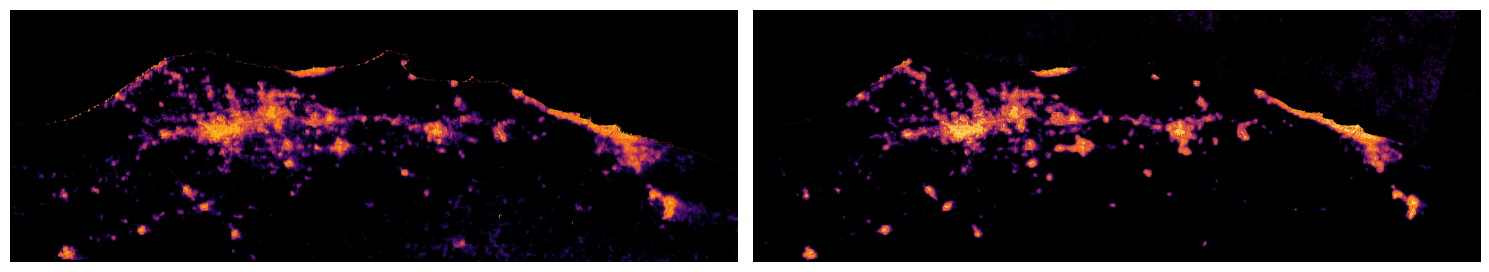

In [159]:
import matplotlib.image as mpimg

# Paths to your image files
image_paths = ['outputs/final/ndui.tif', 'finalBMHD_VNP46A2_Daniel_2023249.tif']  # Replace these with your image paths

# Create subplots for displaying images side by side
fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))  # Adjust figsize as needed

# Load and display images in the subplots
for i, img_path in enumerate(image_paths):
    img = mpimg.imread(img_path)  # Load the image using Matplotlib
    axes[i].imshow(img)  # Display the image in the corresponding subplot
    axes[i].axis('off')  # Hide axes

# Show the subplots
plt.tight_layout()  # Adjust spacing between subplots
plt.show()